# Distance matrix between samples (single-KNN vs double-KNN)
> Required for developing double-KNN correction

- toc: true 
- badges: true
- comments: true

As of now, we are using a KNN correction in the expression space ($\mathbf{Y}$). For each sample, we subtract the mean expression and mean genotype of $K = 30$ nearest neighbors. The nearest neighbors ($NN$) are calculated in the expression space.
\begin{align}
	\mathbf{y}_n & \leftarrow \mathbf{y}_n - \frac{1}{K} \sum_{m \in \mathrm{NN}^K_n} \mathbf{y}_{m} \\
	\mathbf{x}_n & \leftarrow \mathbf{x}_n - \frac{1}{K} \sum_{m \in \mathrm{NN}^K_n} \mathbf{x}_{m}\,.
\end{align}

One idea is to calculate neighbors in the genotype space and perform the KNN correction, before doing the same in the expression space. In this notebook, I have compared the distance matrix between samples after single-KNN (in expression space) and double-KNN (genotype space, followed by expression space).

## Setup

This notebook requires:   
  1. LD filtered genotype
  2. Gene expression matrix

### Python libraries

In [1]:
#collapse-hide
import sys
sys.path.append("../../utils")
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy import stats
import os
from scipy.cluster import hierarchy as hc

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 300)

### Load GT and GX

In [2]:
# #collapse-hide
# dosagefile = '/cbscratch/sbanerj/gtex_pca/gtex_v8_filtered.dosage.raw'
# dosage_numpy_file = '/cbscratch/sbanerj/gtex_pca/gtex_dosage.npy'
# expression_file = '/scratch/sbanerj/trans-eqtl/input/gtex_v8/expression/gtex_ms_raw_std_protein_coding_lncRNA.txt'

In [3]:
import readgt

# Use real genotype
f_vcf = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/ldpruned/GTEX_v8.SHAPEIT2_chr1.ldpruned.vcf.gz"
# samplefile = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_eur.sample"
# samplefile = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_eur_noADM.sample"
# samplefile = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8.sample"
samplefile = None
gtfull, snpinfos, gt_donors = readgt.read_vcf(f_vcf, 0, 1e6, samplefile=samplefile)
snp_info, dosage = readgt.filter_snps(snpinfos, gtfull)


Removed 0 SNPs because of non-single letter polymorphisms
Removed 0 SNPs because of unknown allele symbol
Removed 0 SNPs because of ambiguous strands
Removed 0 SNPs because of unknown RSIDs
Removed 0 SNPs because of low MAF < 0.01
Removed 0 SNPs because of low MAF (current)


In [5]:
#collapse-hide
def read_gtex(filename): # returns N x G gene expression
    expr_list = list()
    donor_list = list()
    gene_list = list()
    with open(filename) as mfile:
        donor_list = mfile.readline().strip().split("\t")[1:]
        for line in mfile:
            linesplit = line.strip().split("\t")
            gene = linesplit[0].strip()
            gene_list.append(gene)
            expr = np.array([float(x) for x in linesplit[1:]])
            expr_list.append(expr)
    expr = np.transpose(np.array(expr_list))
    return expr, donor_list, gene_list

def center_expression(Y): 
    '''
    Y is N x G
    here we center the columns, the mean of the columns (genes) are subtracted
    '''
    Ycent = (Y - np.mean(Y, axis = 0)) / np.std(Y, axis = 0)
    return Ycent

def center_genotype(X):
    '''
    X is N x I
    here we center the columns, the mean of the columns (SNPs) are subtracted
    '''
    return X - np.mean(X, axis = 0).reshape(1, -1)

def center_genotype_rows(X):
    '''
    X is I x N
    here we center the rows, the mean of the rows (SNPs) are subtracted
    '''
    return X - np.mean(X, axis = 1).reshape(-1, 1)

def normalize_expr(Y):
    if isinstance(Y, pd.DataFrame):
        Y_cent = (Y.values - np.mean(Y.values, axis = 1).reshape(-1, 1)) / np.std(Y.values, axis = 1).reshape(-1, 1)
        Y_cent = pd.DataFrame(Y_cent, index=Y.index, columns=Y.columns)
        Y_cent.index.name = Y.index.name
    else:
        Y_cent = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return Y_cent

def select_donors(vcf_donors, expr_donors):
    ''' Make sure that donors are in the same order for both expression and genotype
    '''
    common_donors = [x for x in vcf_donors if x in expr_donors]
    vcfmask = np.array([vcf_donors.index(x) for x in common_donors])
    exprmask = np.array([expr_donors.index(x) for x in common_donors])
    return vcfmask, exprmask

tissue="as"
# expression_file="/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered"
expression_file="/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/popcorr/{:s}_tpms_qcfilter_popcorr.txt.protein_coding_lncRNA_filtered"
# df = pd.read_csv(expression_file.format(tissue), header=0, index_col=0, sep="\t")

gx, gxsamples, _ = read_gtex(expression_file.format(tissue))
# gx = center_expression(gx)
# sampleidx = [gtsamples.index(x) for x in gxsamples] # assumes all expression samples have genotype
# dreduce = dosage[sampleidx, :]
# gt = center_genotype(dreduce) #dreduce - np.mean(dreduce, axis = 0).reshape(1, -1)
##---------------------
# Saikat above's genotype is transposed wrt mine!
##---------------------

print(f"dosage {dosage.shape}")
print(f"gx {gx.shape}")

gx = normalize_expr(gx)
vcfmask, exprmask = select_donors(gt_donors, gxsamples)
gx = normalize_expr( gx[exprmask,:] )
dreduce = dosage[:, vcfmask]
gtnorm, gt = readgt.normalize_and_center_dosage(dreduce, snp_info)
# gt = center_genotype_rows(dreduce) ##same as above

gt = np.transpose(gt)

print(f'{len(vcfmask)} samples, {gx.shape[1]} genes, {gt.shape[1]} SNPs.')

dosage (92433, 838)
gx (578, 15673)
578 samples, 15673 genes, 92433 SNPs.


### Core function modules

1. Calculate PCA, distance matrix and KNN. 
2. Map distance matrix from one sample space to another.  
3. Remove first N principal components from any matrix X.
4. Plotting function.

In [6]:
#collapse-hide
def get_pca(x, K):
    pca = PCA(n_components=K)
    pca.fit(x) # requires N x P (n_samples, n_features)
    x_pca = pca.transform(x)
    return x_pca

def get_distance(a, b):
    return np.linalg.norm(a - b)

def distance_matrix(x_pca):
    nsample = x_pca.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = get_distance(x_pca[i,:], x_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist
    return distance_matrix

def map_distance_matrix(dm, samples, target_samples):
    N = len(target_samples)
    newdm = np.zeros((N, N))
    newdm[:] = np.nan
    for i in range(N):
        if target_samples[i] in samples:
            newdm[i, i] = 0 # diagonal is always zero
            iold = samples.index(target_samples[i])
            for j in range(i+1, N):
                if target_samples[j] in samples:
                    jold = samples.index(target_samples[j])
                    newdm[i, j] = dm[iold, jold]
                    newdm[j, i] = dm[jold, iold]
    return newdm

def knn_old(gx, gt, dm, K, center = True):
    assert (gx.shape[0] == gt.shape[0])
    print(f"GT: {gt.shape}, GX: {gx.shape}")
    N = gx.shape[0]
    gx_knn = np.zeros_like(gx)
    gt_knn = np.zeros_like(gt)

    for i in range(N):
        #neighbors = np.argsort(distance_matrix[i, :kneighbor + 1])
        neighbors = np.argsort(dm[i, :])[:K + 1][1:]
        gx_knn[i, :] = gx[i, :] - np.mean(gx[neighbors, :], axis = 0)
        gt_knn[:, i] = gt[:, i] - np.mean(gt[:, neighbors[1:]], axis = 1)
        if i == 1:
            print(f"old - GX neighbours shape: {np.mean(gx[neighbors, :], axis = 0).shape}")
            print(f"old - GT neighbours shape: {np.mean(gt[:, neighbors[1:]], axis = 1).shape}")
        
    if center:
        gx_knn -= np.mean(gx_knn, axis = 0)
        gt_knn -= np.mean(gt_knn, axis = 0)
        
    return gx_knn, gt_knn

def knn(gx, gt, dm, K, center = True):
    assert (gx.shape[0] == gt.shape[0])
    print(f"GT: {gt.shape}, GX: {gx.shape}")
    N = gx.shape[0]
    gx_knn = np.zeros_like(gx)
    gt_knn = np.zeros_like(gt)

    for i in range(N):
        #neighbors = np.argsort(distance_matrix[i, :kneighbor + 1])
        neighbors = np.argsort(dm[i, :])[:K + 1][1:]
        gx_knn[i, :] = gx[i, :] - np.mean(gx[neighbors, :], axis = 0)
        gt_knn[i, :] = gt[i, :] - np.mean(gt[neighbors[1:], :], axis = 0)
        if i == 1:
            print(f"new - GX neighbours shape: {np.mean(gx[neighbors, :], axis = 0).shape}")
            print(f"new - GT neighbours shape: {np.mean(gt[neighbors[1:], :], axis = 0).shape}")
        
    if center:
        gx_knn -= np.mean(gx_knn, axis = 0)
        gt_knn -= np.mean(gt_knn, axis = 0)
        print(np.mean(gt_knn, axis = 0).shape)
        print(np.mean(gt_knn, axis = 0).reshape(-1, 1).shape)
        
    return gx_knn, gt_knn

def remove_nfirst_pcs(X, n=1):    
    Xnorm = X
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    Xhat = U[:, n:] @ np.diag(S[n:]) @ Vt[n:, :]
    return Xhat

def plot_distance_matrices(dmA, dmB, norms = None):
    '''
    provide norms, if required, as norms = (norm1, norm2)
    where,
    norm1 = matplotlib.colors.DivergingNorm(vmin=10., vcenter=90., vmax=170.)
    norm2 = matplotlib.colors.DivergingNorm(vmin=0., vcenter=90., vmax=300.)
    '''
    
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    # the zero distance between the same samples
    # is bad for the color scale.
    dmA[np.diag_indices(dmA.shape[0])] = np.nan
    dmB[np.diag_indices(dmB.shape[0])] = np.nan

    cmap1 = plt.get_cmap("YlOrRd")
    cmap1.set_bad('w')

    cmap2 = plt.get_cmap("YlGnBu")
    cmap2.set_bad('w')

    if norms is not None:
        norm1 = norms[0]
        norm2 = norms[1]
        im1 = ax1.imshow(dmA, cmap = cmap1, norm = norm1, interpolation='nearest')
        im2 = ax2.imshow(dmB, cmap = cmap2, norm = norm2, interpolation='nearest')
    else:
        im1 = ax1.imshow(dmA, cmap = cmap1, interpolation='nearest')
        im2 = ax2.imshow(dmB, cmap = cmap2, interpolation='nearest')        


    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(im1, cax=cax, fraction = 0.1)

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(im2, cax=cax, fraction = 0.1)

    ax1.set_title("Genotype space", pad = 20)
    ax2.set_title("Expression space", pad = 20)
    
    plt.tight_layout()
    return fig

In [7]:
gt[:10, 580:584]

array([[-0.02249135, -0.02595156, -0.02768166, -0.09861592],
       [-0.02249135, -0.02595156, -0.02768166, -0.09861592],
       [-0.02249135, -0.02595156, -0.02768166, -0.09861592],
       [-0.02249135, -0.02595156, -0.02768166, -0.09861592],
       [-0.02249135, -0.02595156, -0.02768166, -0.09861592],
       [-0.02249135, -0.02595156, -0.02768166, -0.09861592],
       [-0.02249135, -0.02595156, -0.02768166,  0.90138408],
       [-0.02249135, -0.02595156, -0.02768166, -0.09861592],
       [-0.02249135, -0.02595156, -0.02768166,  0.90138408],
       [-0.02249135, -0.02595156, -0.02768166, -0.09861592]])

## Calculation

In [24]:
#collapse-show
# Before KNN
DT = 20 # reduced dimension of genotype
DX = 30 #gx.shape[0] # reduced dimension of expression
dm_gt = distance_matrix(get_pca(gt, DT))
dm_gx = distance_matrix(get_pca(gx, DX))

# # Expression KNN
# K = 30
# gx_knn, gt_knn = knn_old(gx, gt, dm_gx, K)
# dm_gt_knn_old = distance_matrix(get_pca(gt_knn, DT))
# dm_gx_knn_old = distance_matrix(get_pca(gx_knn, DX))

# # Double KNN
# K1 = 10
# K2 = 30
# gx_knn1, gt_knn1 = knn_old(gx, gt, dm_gt, K1)
# dm_gx1 = distance_matrix(get_pca(gx_knn1, DX))
# gx_knn2, gt_knn2 = knn_old(gx_knn1, gt_knn1, dm_gx1, K2)

# dm_gt_knn2_old = distance_matrix(get_pca(gt_knn2, DT))
# dm_gx_knn2_old = distance_matrix(get_pca(gx_knn2, DX))

In [25]:
# Expression KNN
K = 30
gx_knn, gt_knn = knn(gx, gt, dm_gx, K)
dm_gt_knn = distance_matrix(get_pca(gt_knn, DT))
dm_gx_knn = distance_matrix(get_pca(gx_knn, DX))

# Double KNN
K1 = 10
K2 = 30
gx_knn1, gt_knn1 = knn(gx, gt, dm_gt, K1)
dm_gx1 = distance_matrix(get_pca(gx_knn1, DX))
gx_knn2, gt_knn2 = knn(gx_knn1, gt_knn1, dm_gx1, K2)

dm_gt_knn2 = distance_matrix(get_pca(gt_knn2, DT))
dm_gx_knn2 = distance_matrix(get_pca(gx_knn2, DX))

dm_gt_knn1 = distance_matrix(get_pca(gt_knn1, DT))
dm_gx_knn1 = distance_matrix(get_pca(gx_knn1, DX))

GT: (578, 92433), GX: (578, 15673)
new - GX neighbours shape: (15673,)
new - GT neighbours shape: (92433,)
(92433,)
(92433, 1)
GT: (578, 92433), GX: (578, 15673)
new - GX neighbours shape: (15673,)
new - GT neighbours shape: (92433,)
(92433,)
(92433, 1)
GT: (578, 92433), GX: (578, 15673)
new - GX neighbours shape: (15673,)
new - GT neighbours shape: (92433,)
(92433,)
(92433, 1)


### Option 1. Order samples in genotype space

In [26]:
#collapse-hide
o1 = hc.leaves_list(hc.linkage(dm_gt, method = 'centroid'))

/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


Define the color bar scales

In [27]:
#collapse-hide
norm1 = matplotlib.colors.DivergingNorm(vmin=10., vcenter=90., vmax=170.)
# norm2 = matplotlib.colors.DivergingNorm(vmin=0., vcenter=90., vmax=300.)
norm2 = matplotlib.colors.DivergingNorm(vmin=50., vcenter=90., vmax=140.)

# norm2 = matplotlib.colors.DivergingNorm(vmin=150., vcenter=175., vmax=200.)
norms = (norm1, norm2)

/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  
/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  after removing the cwd from sys.path.


### Check singular values before and after

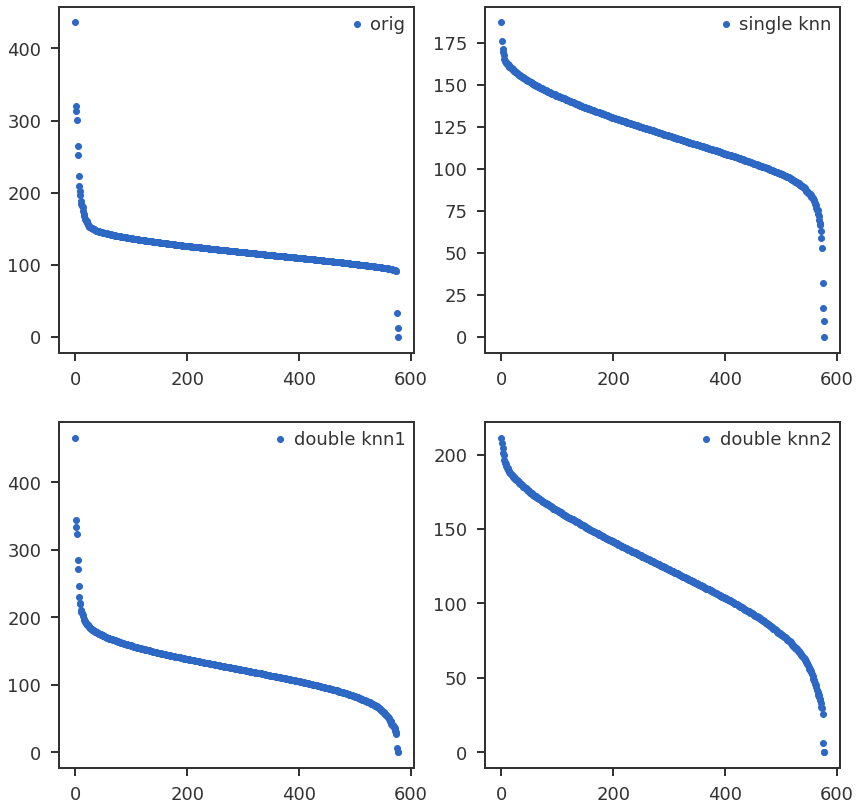

In [32]:
u, s, vt = np.linalg.svd(gx, full_matrices=False)
u, s_knn, vt = np.linalg.svd(gx_knn, full_matrices=False)
u, s_knn1, vt = np.linalg.svd(gx_knn1, full_matrices=False)
u, s_knn2, vt = np.linalg.svd(gx_knn2, full_matrices=False)

fig = plt.figure(figsize=(14,14))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(np.arange(len(s)), s, label="orig")
ax2.scatter(np.arange(len(s_knn)), s_knn, label="single knn")
ax3.scatter(np.arange(len(s_knn1)), s_knn1, label="double knn1")
ax4.scatter(np.arange(len(s_knn2)), s_knn2, label="double knn2")

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.show()

Plot the distance matrix in genotype space and expression space

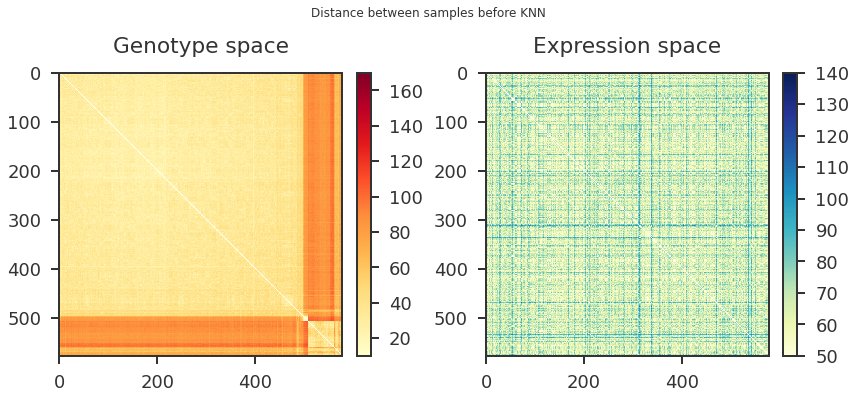

In [28]:
#collapse-show
mgt = dm_gt[o1, :][:, o1]
mgx = dm_gx[o1, :][:, o1]
fig = plot_distance_matrices(mgt, mgx, norms = norms)
fig.suptitle("Distance between samples before KNN")
plt.show()

In [13]:
# #collapse-show
# mgt = dm_gt_knn_old[o1, :][:, o1]
# mgx = dm_gx_knn_old[o1, :][:, o1]
# fig = plot_distance_matrices(mgt, mgx, norms = norms)
# fig.suptitle("Distance between samples after single-KNN (Old)")
# plt.show()

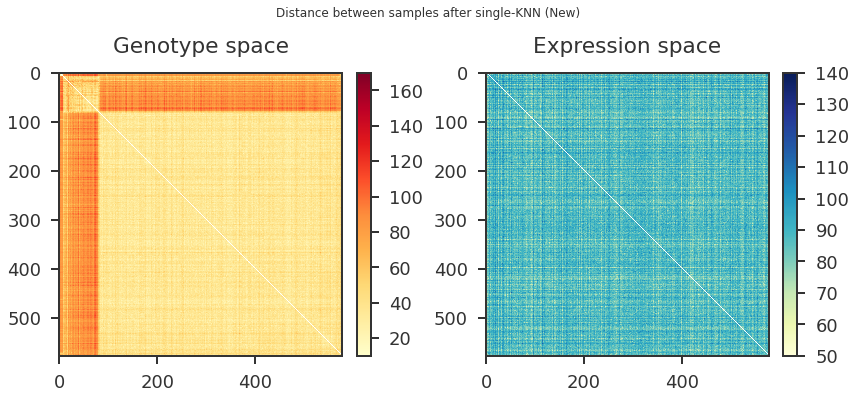

In [14]:
#collapse-show
mgt = dm_gt_knn[o1, :][:, o1]
mgx = dm_gx_knn[o1, :][:, o1]
fig = plot_distance_matrices(mgt, mgx, norms = norms)
fig.suptitle("Distance between samples after single-KNN (New)")
plt.show()

In [15]:
# #collapse-show
# mgt = dm_gt_knn2_old[o1, :][:, o1]
# mgx = dm_gx_knn2_old[o1, :][:, o1]
# fig = plot_distance_matrices(mgt, mgx, norms = norms)
# fig.suptitle("Distance between samples after double-KNN (Old)")
# plt.show()

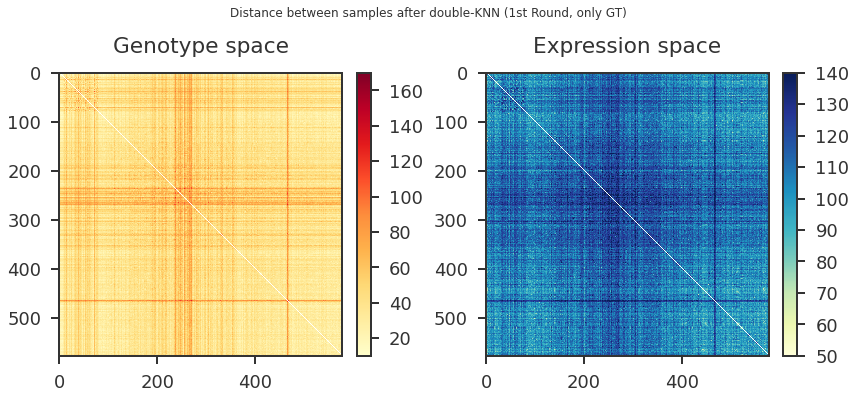

In [16]:
#collapse-show NEW
mgt = dm_gt_knn1[o1, :][:, o1]
mgx = dm_gx_knn1[o1, :][:, o1]
fig = plot_distance_matrices(mgt, mgx, norms = norms)
fig.suptitle("Distance between samples after double-KNN (1st Round, only GT)")
plt.show()

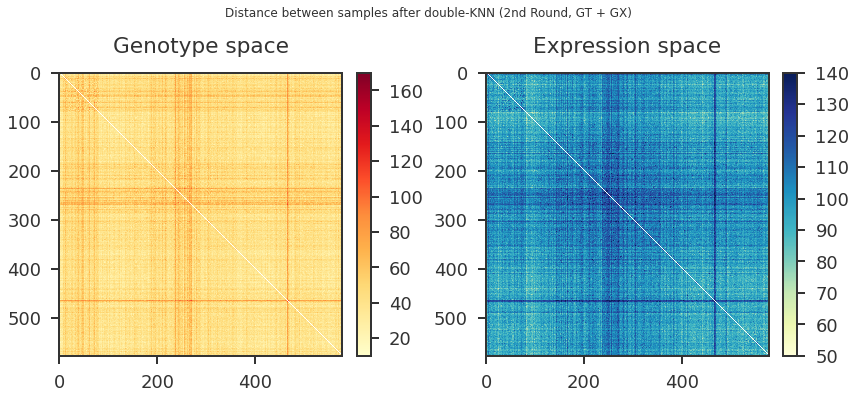

In [17]:
#collapse-show NEW
mgt = dm_gt_knn2[o1, :][:, o1]
mgx = dm_gx_knn2[o1, :][:, o1]
fig = plot_distance_matrices(mgt, mgx, norms = norms)
fig.suptitle("Distance between samples after double-KNN (2nd Round, GT + GX)")
plt.show()

### Option 2. Order samples in expression space

In [18]:
#collapse-hide
o2 = hc.leaves_list(hc.linkage(dm_gx, method='centroid'))

/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


Use the same color bar scale as above and plot the distance matrices.

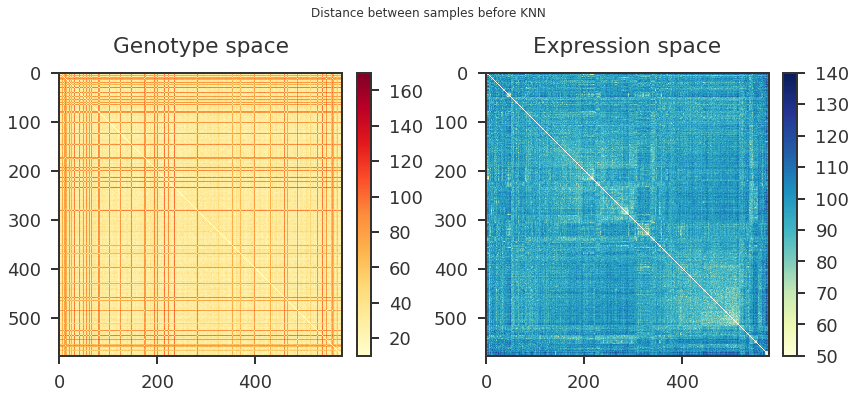

In [19]:
#collapse-show
mgt = dm_gt[o2, :][:, o2]
mgx = dm_gx[o2, :][:, o2]
fig = plot_distance_matrices(mgt, mgx, norms = norms)
fig.suptitle("Distance between samples before KNN")
plt.show()

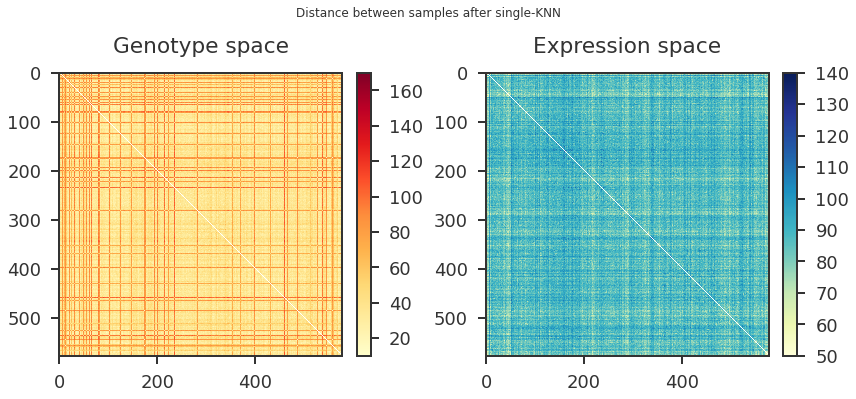

In [20]:
#collapse-show
mgt = dm_gt_knn[o2, :][:, o2]
mgx = dm_gx_knn[o2, :][:, o2]
fig = plot_distance_matrices(mgt, mgx, norms = norms)
fig.suptitle("Distance between samples after single-KNN")
plt.show()

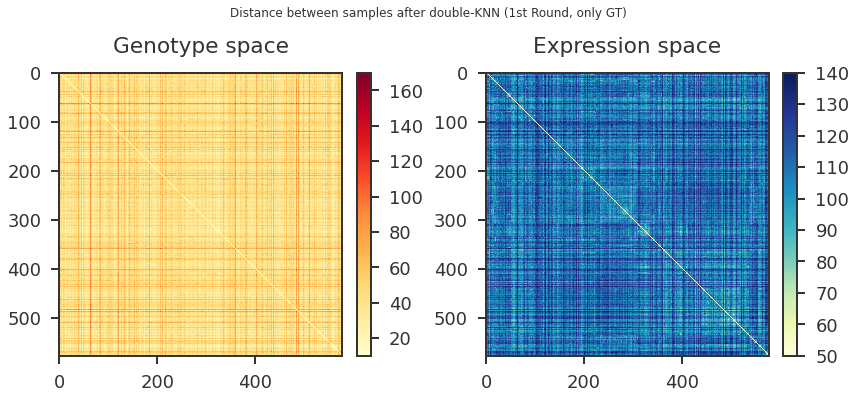

In [21]:
#collapse-show NEW
mgt = dm_gt_knn1[o2, :][:, o2]
mgx = dm_gx_knn1[o2, :][:, o2]
fig = plot_distance_matrices(mgt, mgx, norms = norms)
fig.suptitle("Distance between samples after double-KNN (1st Round, only GT)")
plt.show()

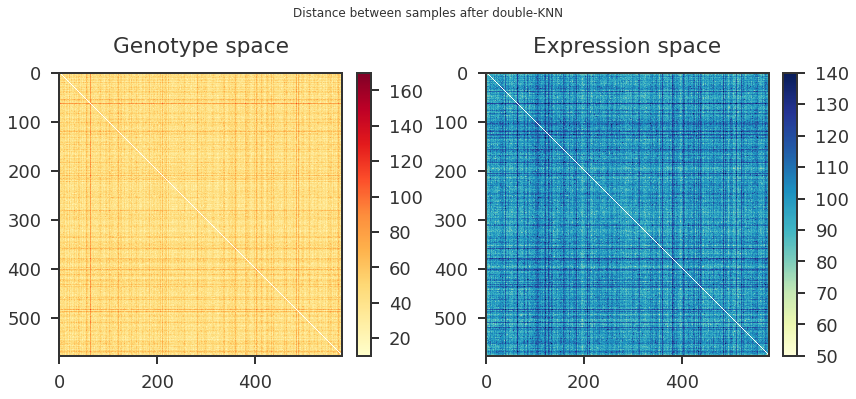

In [22]:
#collapse-show
mgt = dm_gt_knn2[o2, :][:, o2]
mgx = dm_gx_knn2[o2, :][:, o2]
fig = plot_distance_matrices(mgt, mgx, norms = norms)
fig.suptitle("Distance between samples after double-KNN")
plt.show()

### Difference between KNN and double-KNN

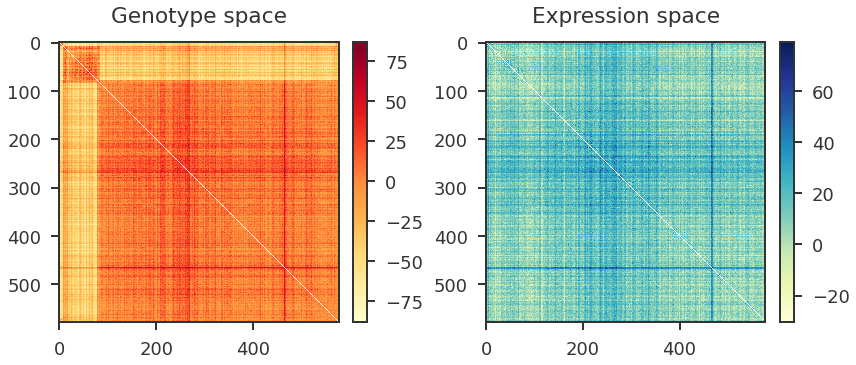

In [23]:
#collapse-show
mgt = dm_gt_knn2[o1, :][:, o1] - dm_gt_knn[o1, :][:, o1]
mgx = dm_gx_knn2[o1, :][:, o1] - dm_gx_knn[o1, :][:, o1]
fig = plot_distance_matrices(mgt, mgx)
plt.show()